# Echo State Network homework

In [2]:
!pip install brainpy_datasets

  Obtaining dependency information for brainpy_datasets from https://files.pythonhosted.org/packages/67/98/5a4a508646e457593aaaa8f4c723ee0e44aee1d206ed8be99db8c356c89e/brainpy_datasets-0.0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 458.6 kB/s eta 0:00:000:00:010m


In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import matplotlib.pyplot as plt

# enable x64 computation
bm.set_environment(x64=True, mode=bm.batching_mode)
bm.set_platform('cpu')

c:\Users\13107\.conda\envs\brainpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Echo State Network  

Echo State Networks (ESNs) are applied to supervised temporal machine learning tasks where for a given training input signal $x(n)$ a desired target output signal $y^{target}(n)$ is known. Here $n=1, ..., T$ is the discrete time and  $T$ is the number of data points in the training dataset.  

The task is to learn a model with output $y(n)$, where $y(n)$ matches $y^{target}(n)$ as well as possible, minimizing an error measure $E(y, y^{target})$, and, more importantly, generalizes well to unseen data.

ESNs use an RNN type with leaky-integrated discrete-time continuous-value units. The typical update equations are  

$$  
\hat{h}(n) = \tanh(W^{in} x(n) + W^{rec}h(n-1) + W^{fb}y(n-1) + b^{rec}) \\  
h(n) = (1 - \alpha) x(n-1)+\alpha \hat{h}(n)  
$$  

where $h(n)$ is a vector of reservoir neuron activations, $W^{in}$ and $W^{rec}$ are the input and recurrent weight matrices respectively, and $\alpha \in (0, 1]$ is the leaking rate. The model is also sometimes used without the leaky integration, which is a special case of $\alpha=1$.

The linear readout layer is defined as  

$$  
y(n) = W^{out} h(n) + b^{out}  
$$  

where $y(n)$ is network output, $W^{out}$ the output weight matrix, and $b^{out}$ is the output bias.  

An additional nonlinearity can be applied to $y(n)$, as well as feedback connections $W^{fb}$ from $y(n-1)$ to $\hat{h}(n)$.

A graphical representation of an ESN illustrating our notation and the idea for training is depicted in the following figure.  


![Image Name](https://cdn.kesci.com/upload/s033zeaqrs.png?imageView2/0/w/640/h/640)  



## Ridge regression  

Finding the optimal weights $W^{out}$ that minimize the squared error between $y(n)$ and $y^{target}(n)$ amounts to solving a typically overdetermined system of linear equations  

$$  
Y^{target} = W^{out}X  
$$  

Probably the most universal and stable solution is ridge regression, also known as regression with Tikhonov regularization:  

$$  
W^{out} = Y^{target}X^T(XX^T+\beta I)^{-1}  
$$

## Dataset  

Mackey-Glass equation are a set of delayed differential equations describing the temporal behaviour of different physiological signal, for example, the relative quantity of mature blood cells over time.  

The equations are defined as:  

$$  
\frac{dP(t)}{dt} = \frac{\beta P(t - \tau)}{1 + P(t - \tau)^n} - \gamma P(t)  
$$  

where $\beta = 0.2$, $\gamma = 0.1$, $n = 10$, and the time delay $\tau = 17$. $\tau$ controls the chaotic behaviour of the equations (the higher it is, the more chaotic the timeserie becomes. $\tau=17$ already gives good chaotic results.)

In [2]:
def plot_mackey_glass_series(ts, x_series, x_tau_series, num_sample):
  plt.figure(figsize=(13, 5))

  plt.subplot(121)
  plt.title(f"Timeserie - {num_sample} timesteps")
  plt.plot(ts[:num_sample], x_series[:num_sample], lw=2, color="lightgrey", zorder=0)
  plt.scatter(ts[:num_sample], x_series[:num_sample], c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$t$")
  plt.ylabel("$P(t)$")

  ax = plt.subplot(122)
  ax.margins(0.05)
  plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
  plt.plot(x_tau_series[: num_sample], x_series[: num_sample], lw=1, color="lightgrey", zorder=0)
  plt.scatter(x_tau_series[:num_sample], x_series[: num_sample], lw=0.5, c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$P(t-\\tau)$")
  plt.ylabel("$P(t)$")
  cbar = plt.colorbar()
  cbar.ax.set_ylabel('$t$')

  plt.tight_layout()
  plt.show()

An easy way to get Mackey-Glass time-series data is using ``brainpy.dataset.mackey_glass_series()``. If you want to see the details of the implementation, please see the corresponding source code.

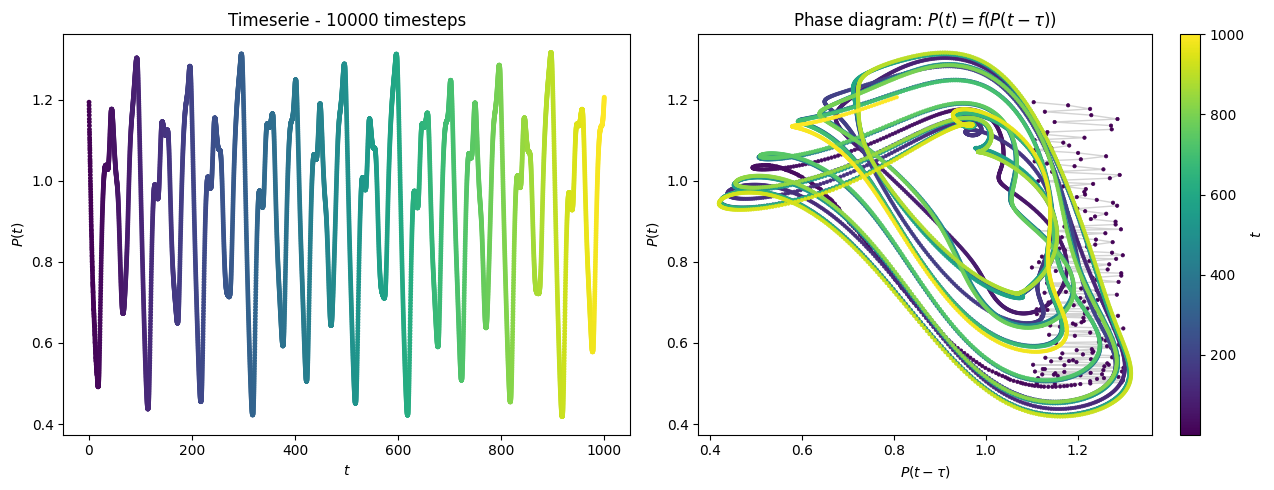

In [3]:
dt = 0.1
mg_data = bd.chaos.MackeyGlassEq(25000, dt=dt, tau=17, beta=0.2, gamma=0.1, n=10)
ts = mg_data.ts
xs = mg_data.xs
ys = mg_data.ys

plot_mackey_glass_series(ts, xs, ys, num_sample=int(1000 / dt))

## Task 1: prediction of Mackey-Glass timeseries  

Predict $P(t+1), \cdots, P(t+N)$ from $P(t)$.

### Prepare the data

In [4]:
def get_data(t_warm, t_forcast, t_train, sample_rate=1):
    warmup = int(t_warm / dt)  # warmup the reservoir
    forecast = int(t_forcast / dt)  # predict 10 ms ahead
    train_length = int(t_train / dt)

    X_warm = xs[:warmup:sample_rate]
    X_warm = bm.expand_dims(X_warm, 0)

    X_train = xs[warmup: warmup+train_length: sample_rate]
    X_train = bm.expand_dims(X_train, 0)

    Y_train = xs[warmup+forecast: warmup+train_length+forecast: sample_rate]
    Y_train = bm.expand_dims(Y_train, 0)

    X_test = xs[warmup + train_length: -forecast: sample_rate]
    X_test = bm.expand_dims(X_test, 0)

    Y_test = xs[warmup + train_length + forecast::sample_rate]
    Y_test = bm.expand_dims(Y_test, 0)

    return X_warm, X_train, Y_train, X_test, Y_test

In [5]:
# First warmup the reservoir using the first 100 ms
# Then, train the network in 20000 ms to predict 1 ms chaotic series ahead
x_warm, x_train, y_train, x_test, y_test = get_data(100, 1, 20000)

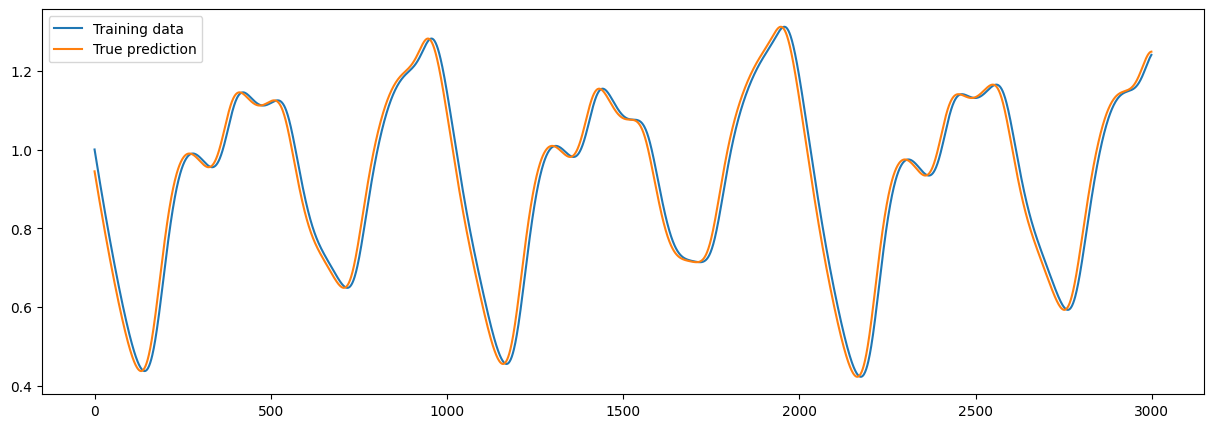

In [6]:
sample = 3000
fig = plt.figure(figsize=(15, 5))
plt.plot(x_train[0, :sample], label="Training data")
plt.plot(y_train[0, :sample], label="True prediction")
plt.legend()
plt.show()

### Prepare the ESN

Please fill the blanks in the following code:

In [7]:
# Construct the ESN
class ESN(bp.DynamicalSystemNS):
  def __init__(self, num_in, num_hidden, num_out, sr=1., leaky_rate=0.3,
               Win_initializer=bp.init.Uniform(0, 0.2)):
    super(ESN, self).__init__()
    # TODO: complete the reservoir module
    self.r = bp.layers.Reservoir(
        num_in,num_hidden,
        Win_initializer=Win_initializer,
        leaky_rate=leaky_rate
    )
    # TODO: complete the readout module
    self.o = bp.layers.Dense(num_hidden,num_out,mode=bm.training_mode)

  def update(self, x):
    # TODO: complete the update function
    return x >> self.r >>self.o

### Train and test ESN

In [8]:
model = ESN(1, 100, 1)
model.reset_state(1)
# TODO: initialize the trainer, set alpha=1e-6
trainer = bp.RidgeTrainer(model,alpha=1e-6)

In [9]:
# warmup
# TODO: warmup the reservoir
_=trainer.predict(x_warm)

Predict 1000 steps: :   0%|          | 0/1000 [00:00<?, ?it/s]

Predict 1000 steps: : 100%|██████████| 1000/1000 [00:00<00:00, 10690.48it/s]


In [10]:
# train
# TODO: train the reservoir
_=trainer.fit([x_train, y_train])

Predict 200000 steps: :   0%|          | 0/200000 [00:00<?, ?it/s]

Train 1 nodes: : 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


### Test the training data.

In [11]:
# Test
# TODO: test the reservoir with train data
ys_predict = ys_predict = trainer.predict(x_train)

Predict 200000 steps: : 100%|██████████| 200000/200000 [00:01<00:00, 139982.83it/s]


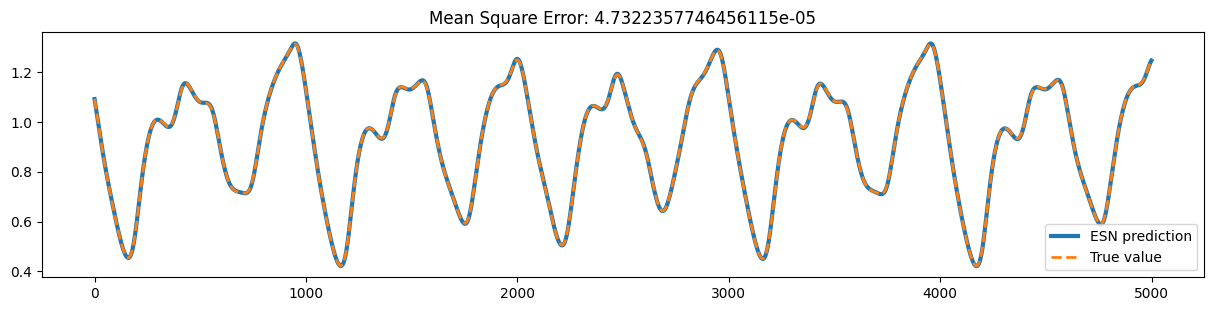

In [12]:
start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0],
         lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_train)[0, start:end, 0], linestyle="--",
         lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_train)}')
plt.legend()
plt.show()

### Test the testing data.

Predict 48990 steps: :   0%|          | 0/48990 [00:00<?, ?it/s]

Predict 48990 steps: : 100%|██████████| 48990/48990 [00:00<00:00, 114804.06it/s]


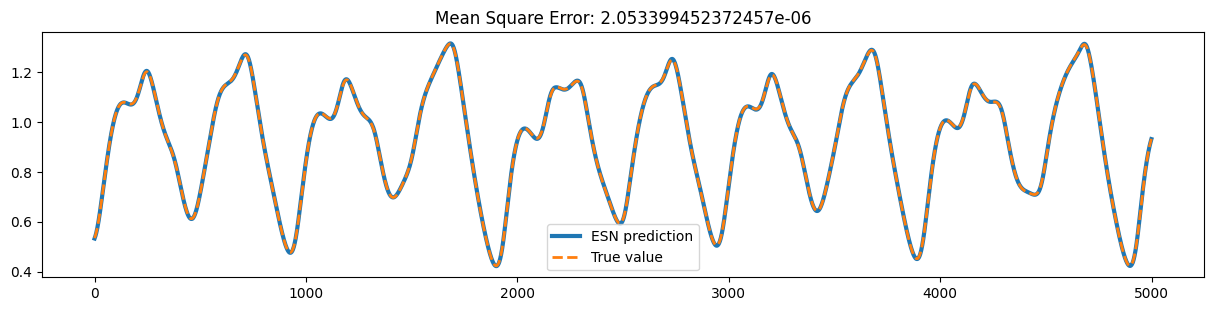

In [13]:
# TODO: test the reservoir with test data
ys_predict = trainer.predict(x_test)

start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_test)[0,start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_test)}')
plt.legend()
plt.show()

### Make the task harder

In [14]:
# First warmup the reservoir using the first 100 ms
# Then, train the network in 20000 ms to predict 10 ms chaotic series ahead
x_warm, x_train, y_train, x_test, y_test = get_data(100, 20, 20000)

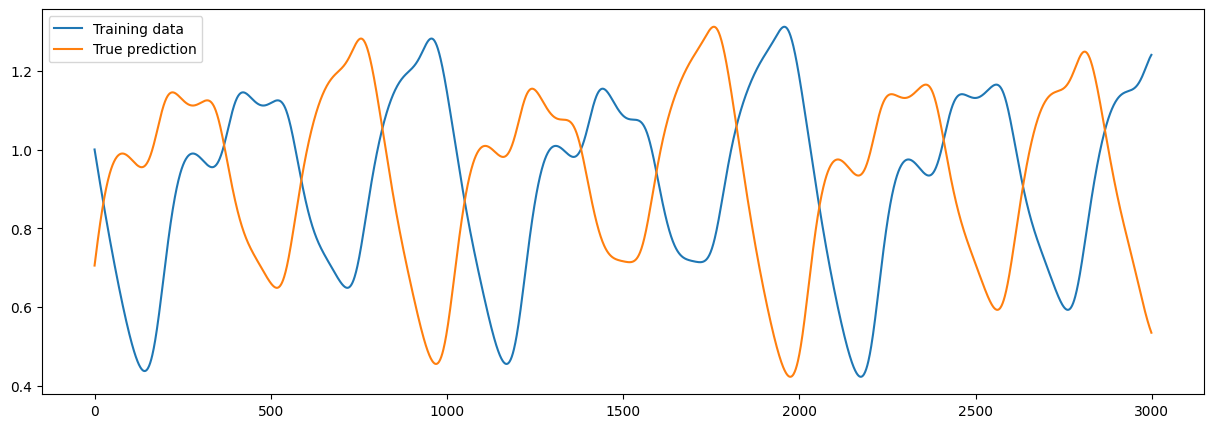

In [15]:
sample = 3000
plt.figure(figsize=(15, 5))
plt.plot(x_train[0, :sample], label="Training data")
plt.plot(y_train[0, :sample], label="True prediction")
plt.legend()
plt.show()

In [16]:
model = ESN(1, 100, 1, sr=1.1)
model.reset_state(1)
# TODO: initialize the trainer, set alpha=1e-6
trainer = bp.RidgeTrainer(model,alpha=1e-6)

In [17]:
# warmup
# TODO: warmup the reservoir
_=trainer.predict(x_warm)

# train
# TODO: train the reservoir
_=trainer.fit([x_train, y_train])

Train 1 nodes: : 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Predict 48800 steps: :   0%|          | 0/48800 [00:00<?, ?it/s]

Predict 48800 steps: : 100%|██████████| 48800/48800 [00:00<00:00, 115811.65it/s]


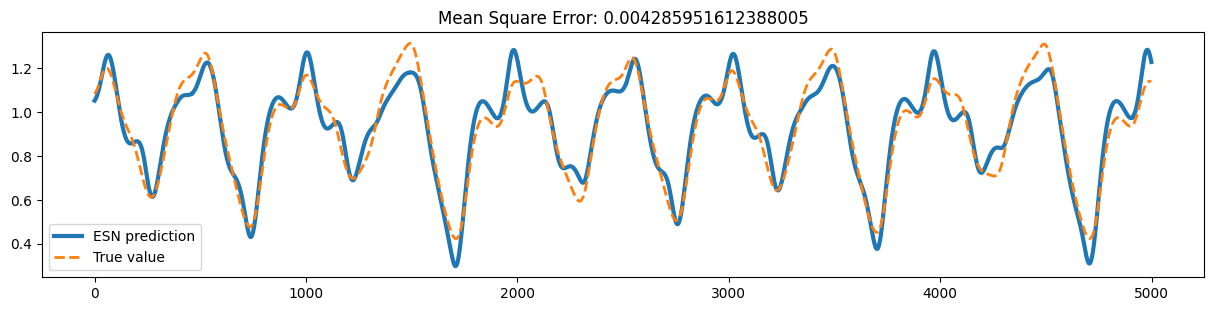

In [18]:
# TODO: test the reservoir with test data
ys_predict = trainer.predict(x_test)

start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_test)[0, start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_test)}')
plt.legend()
plt.show()

### Diving into the reservoir  

Let's have a look at the effect of some of the hyperparameters of the ESN.

#### Spectral radius  

The spectral radius is defined as the maximum eigenvalue of the reservoir matrix.

Predict 10000 steps: : 100%|██████████| 10000/10000 [00:00<00:00, 71844.88it/s]


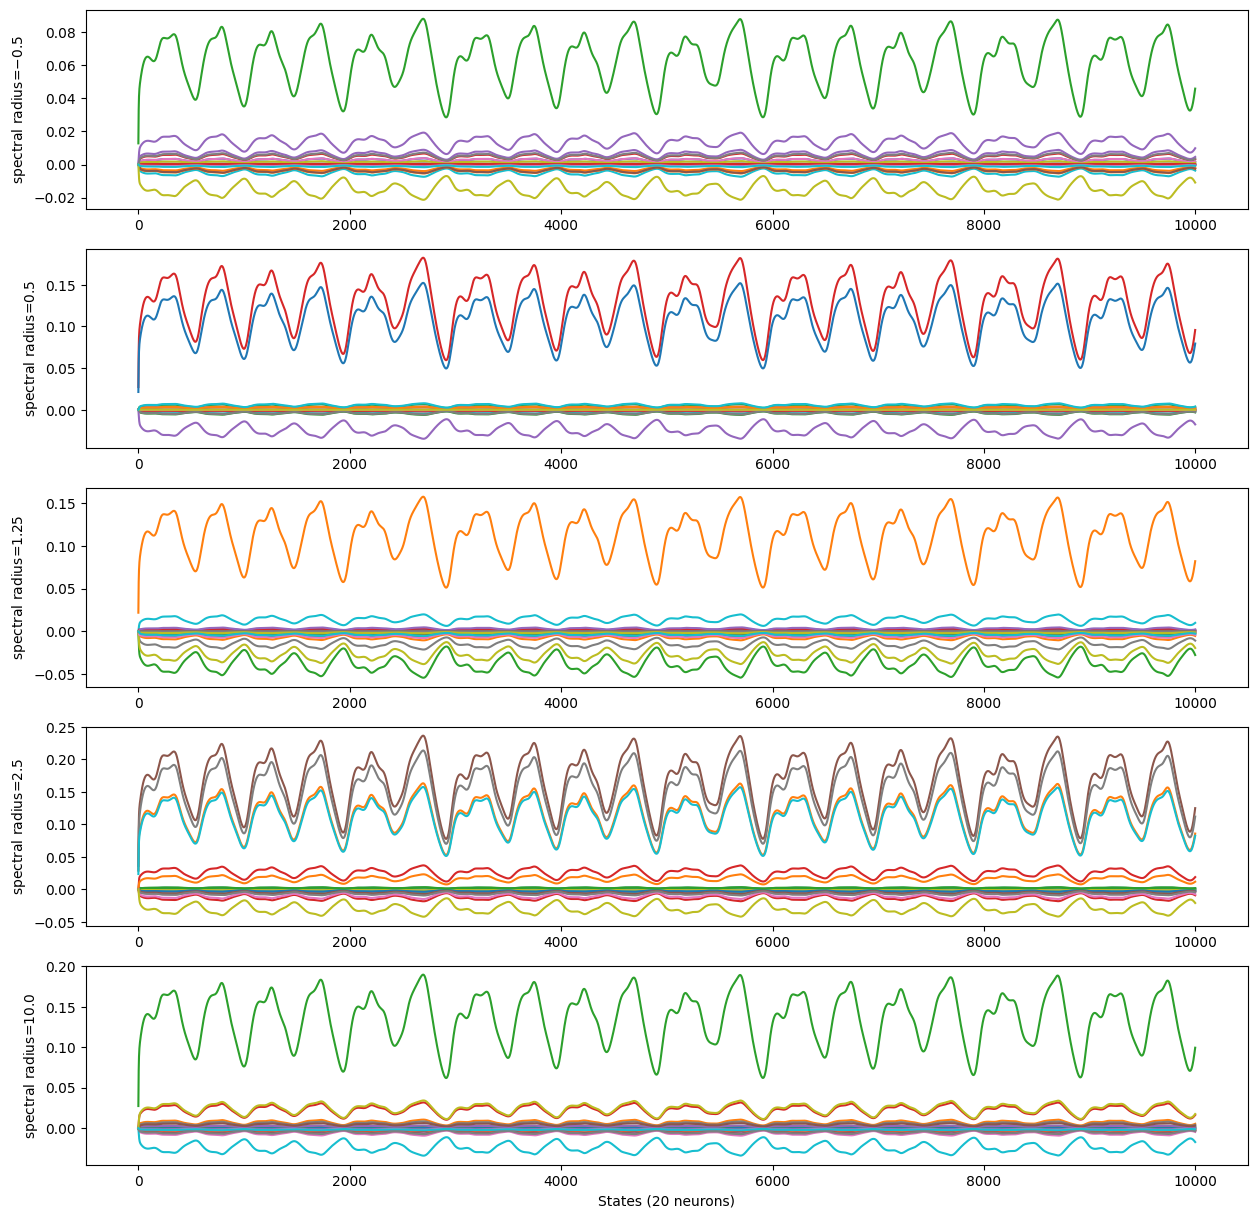

In [19]:
num_sample = 20
all_radius = [-0.5, 0.5, 1.25, 2.5, 10.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_radius):
  # TODO: initialize the ESN with different spectral radius and simulate
  model = ESN(1,100,1,sr=s)
  model.reset_state(1)
  runner = bp.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"spectral radius=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()


- spectral radius < 1 $\rightarrow$ **stable** dynamics  

- spectral radius > 1 $\rightarrow$ **chaotic** dynamics  

In most cases, it should have a value around $1.0$ to ensure the *echo state property* (ESP): the dynamics of the reservoir should not be bound to the initial state chosen, and remains close to chaos.  

This value also heavily depends on the input scaling.  


#### Input scaling  

The input scaling controls how the ESN interact with the inputs. It is a coefficient appliyed to the input matrix $W^{in}$.  


Predict 10000 steps: : 100%|██████████| 10000/10000 [00:00<00:00, 68242.23it/s]


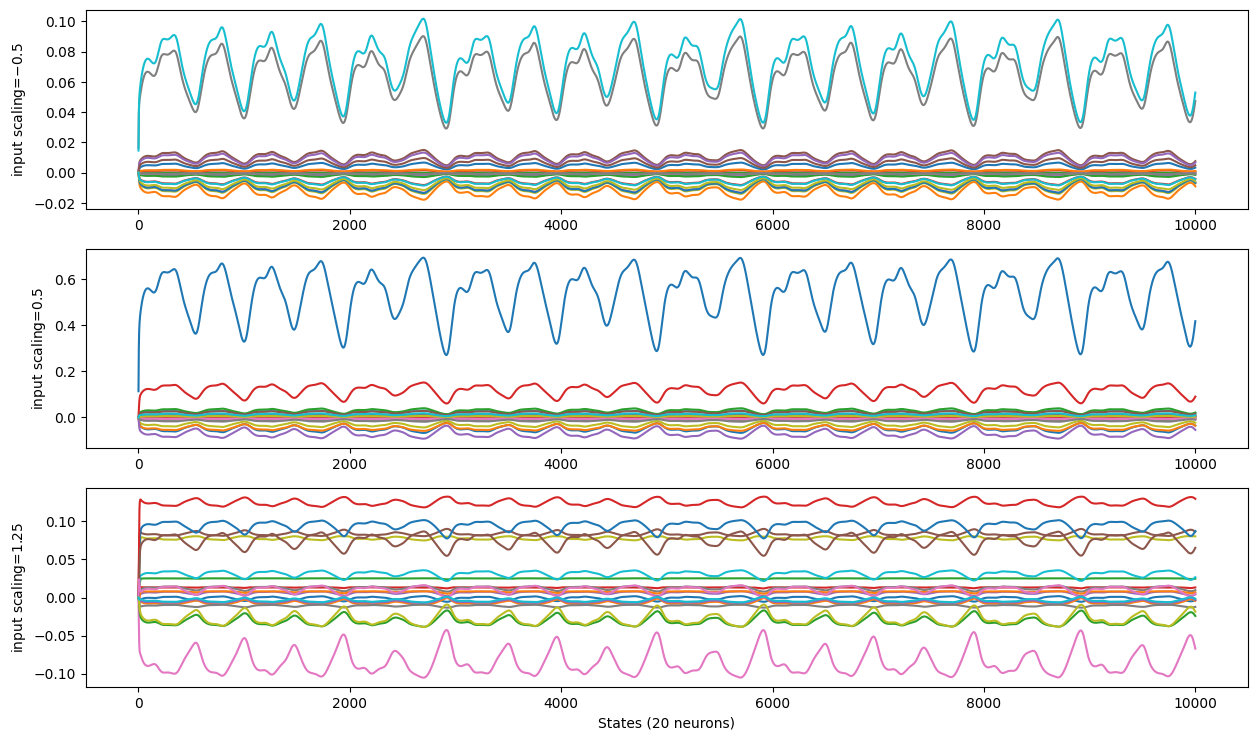

In [20]:
num_sample = 20
all_input_scaling = [0.1, 1.0, 10.0]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_input_scaling):
  # TODO: initialize the ESN with different input scaling and simulate
  model = ESN(1, 100, 1, sr=1., Win_initializer=bp.init.Uniform(max_val=s))
  model.reset_state(1)
  runner = bp.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"input scaling=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

#### Leaking rate  

The leaking rate ($\alpha$) controls the "memory feedback" of the ESN. The ESN states are indeed computed as:  

$$  
h(t+1) =  \underbrace{\color{red}{(1 - \alpha)} h(t)}_{\text{previous states}} + \underbrace{\color{red}\alpha f(x(t+1), h(t))}_{\text{new states}}  
$$  

where $h$ is the state, $x$ is the input data, $f$ is the ESN model function, defined as:  

$$  
f(x, h) = \tanh(W^{in} \cdotp x + W^{rec} \cdotp h)  
$$  

$\alpha$ must be in $[0, 1]$.

Predict 10000 steps: : 100%|██████████| 10000/10000 [00:00<00:00, 67573.23it/s]


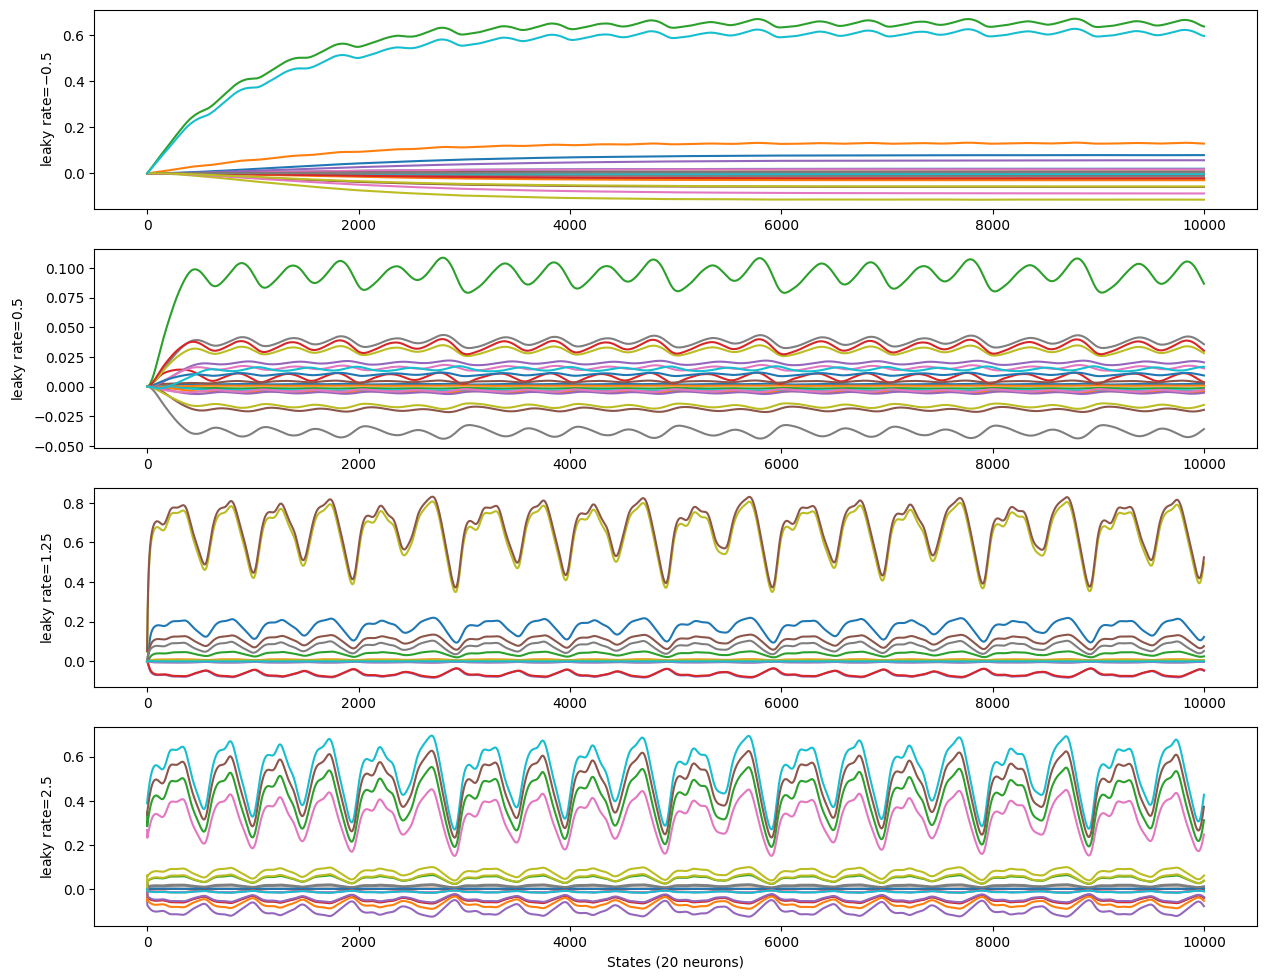

In [21]:
num_sample = 20
all_rates = [0.001, 0.01, 0.1, 1.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_rates):
  # TODO: initialize the ESN with different leaky rate and simulate
  model = ESN(1, 100, 1, sr=1., leaky_rate=s,
              Win_initializer=bp.init.Uniform(max_val=1.), )
  model.reset_state(1)
  runner = bp.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"leaky rate=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

Let's reduce the input influence to see what is happening inside the reservoir (input scaling set to 0.2):

Predict 10000 steps: : 100%|██████████| 10000/10000 [00:00<00:00, 45298.97it/s]


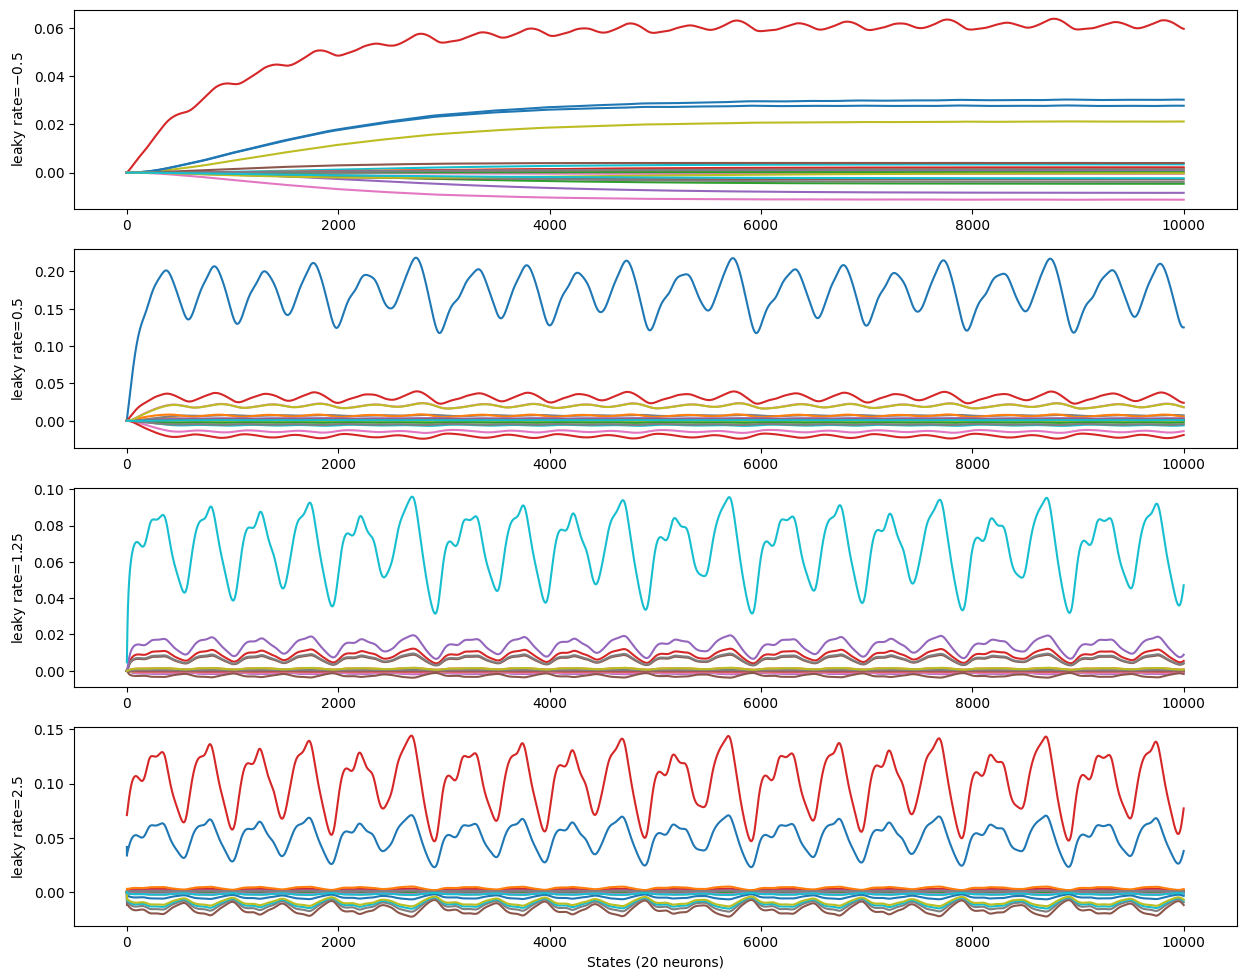

In [22]:
num_sample = 20
all_rates = [0.001, 0.01, 0.1, 1.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_rates):
  model = ESN(1, 100, 1, sr=1., leaky_rate=s,
              Win_initializer=bp.init.Uniform(max_val=.2), )
  # TODO: reset the ESN with different leaky rate and simulate
  model.reset_state(1)
  runner = bp.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"leaky rate=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

- high leaking rate $\rightarrow$ **low inertia**, little memory of previous states  
- low leaking rate $\rightarrow$ **high inertia**, big memory of previous states  

The leaking rate can be seen as the inverse of the reservoir's time contant.  
